**Maestría en Inteligencia Artificial Aplicada**

**Curso: Proyecto Integrador**

**Tecnológico de Monterrey**

**Equipo 9**

**Jorge Luis Arroyo Chavelas (A01793023)**

<span style="font-size:larger;">**Avance 5. Modelo Final**</span>

# Job Market Assignation

## Introduction

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In this document, we delve into the process of job assignment with a programmatic approach. We're looking at a job market divided into two main players: tasks, which we'll refer to as 'jobs', and applicants, which we'll call 'resources'. Our role is akin to a central hub, tasked with connecting client projects with the right mix of hired and available talent to secure financial benefits.
    </p>
    <p>
        WWe'll consider factors such as timing, compensation, and skill compatibility. The 'matching score', developed using NLP techniques, helps us determine how well a resource fits a project's requirements. The timing aspect is flexible; jobs within projects are introduced in sequences at intervals like t+0, t+1, ..., t+n. This setup means that resources might be engaged in earlier projects, affecting their availability for new assignments. Compensation includes the projected income from job placements and related costs such as salaries, recruitment expenses, and potential training. We aim to integrate these elements of time, skill match, and financial considerations to identify optimal solutions for this simulated market.
    </p>
    <p>
        Ultimately, we will develop an integrated solution, that processes job vacancies and candidate profiles to produce matches based on either simulated or actual data.
    </p>
    <p>
        To start the alchemy, let's first prepare the lab!
    </p>
</div>

In [1]:
# -----------------------------------------------------------------------------------------------
# Get libraries and set up env variables for project
# -----------------------------------------------------------------------------------------------


## Env and interface libraries
import os
import warnings
from dotenv import load_dotenv
from tqdm import tqdm

warnings.simplefilter("ignore", UserWarning)

## Data call and manipulation
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from sqlalchemy import create_engine, text
from names import get_full_name



## ML/DL
import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from openai import OpenAI

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable


# Call env variables
load_dotenv()

# Select torch device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

/Users/dataalchemist/Documents/Tec/Proyecto Integrador/IRPO/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To call the data, we will do one of two strategies, we will either call the data from the database or from csv files. This is controlled by the following global variable
    </p>
</div>

In [2]:
## Choose if you have access to postgres DB or not.
DB_ACCESS = True

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        And now the data...
    </p>
</div>

In [3]:
# -----------------------------------------------------------------------------------------------
# Call initial data
# -----------------------------------------------------------------------------------------------


## HTML clean function for job data.
def clean_html(raw_html):
    soup = BeautifulSoup(raw_html, 'html.parser')

    # Iterate through all elements in the parsed HTML
    output = []
    for element in soup.find_all():
        if element.name in ['div', 'p']:
            output.append('\n') 
        else:
            output.append(element.get_text().strip())

    cleaned_text = ' '.join(output) 

    cleaned_text = re.sub(r'\n+', '\n', cleaned_text)
    cleaned_text = cleaned_text.replace(u'\xa0', u' ')

    return cleaned_text

## Call data from db or csv
if DB_ACCESS:
    # Database connection
    DATABASE_URL = os.getenv("DATABASE_URL")
    engine = create_engine(DATABASE_URL)

    # Queries to call the data
    RESOURCE_QUERY = """
        SELECT	DISTINCT
                resource_title
                , resource_education
                , resource_experience
                , resource_skills
                , resource_text
                , random() AS r
        FROM	ml_resource
        WHERE 	resource_text ~* '(html|javascript|python|data science|data engineering|css|scrum|designer)'
                OR resource_title ~* '(data|developer)'
        ORDER BY random() 
        LIMIT 	1000;
        """
    
    JOB_QUERY = """
        SELECT 	DISTINCT
                job_title
                , job_html
                , random() AS r
        FROM 	ml_task
        WHERE 	job_description ~* '(html|javascript|python|data science|data engineering|css|scrum|designer)'
                OR job_title ~* '(data|developer)'
        ORDER BY random() 
        LIMIT 	1000;
        """

    # Call df resource data
    df_resource = pd.read_sql(text(RESOURCE_QUERY), engine.connect())
    df_resource.drop(['r'], axis=1, inplace=True)

     # Call df job data
    df_job = pd.read_sql(text(JOB_QUERY), engine.connect())
    df_job['job_text'] = df_job['job_html'].apply(clean_html)
    df_job.drop(['job_html', 'r'], axis=1, inplace=True)
    
    # Save the data for reproducibility
    df_resource.to_csv('./df_resource.csv')
    df_job.to_csv('./df_job.csv', index=False)

else:
    # call data through csv files
    df_job = pd.read_csv('./df_job.csv')
    df_resource = pd.read_csv('./df_resource.csv')

## Display data
print(f'\n Resource df shape: {df_resource.shape}')
display(df_resource.head())

print(f'\n Job df shape: {df_job.shape}')
display(df_job.head())


 Resource df shape: (1000, 5)


,resource_title,resource_education,resource_experience,resource_skills,resource_text
0,data scientist,Education\nMaster of Science: Applied Statisti...,"Work History\nData Scientist, 06/2019 - Curren...","Database: MySQL, Postgres SQL, MongoDB,\nProgr...",Jessica Claire\n100 Montgomery St. 10th Floor ...
1,data entry,Education\nHigh School Diploma: 1994\nManchest...,"Experience\nData Entry, 09/2014 to Current\nEu...",Microsoft Office proficiency\nExcel spreadshee...,"Jessica Claire\nMontgomery Street, San Francis..."
2,senior analyst data center,Education and Training\nAssociate: Science Bus...,Experience\n01/2014 to Current\nSenior Analyst...,Market Research and Analysis\nMarketing Strate...,"Jessica Claire\nMontgomery Street, San Francis..."
3,sr. automation engineer,"EDUCATION\nEast West University\nChicago, IL 2...",EXPERIENCE\nAccenture Contractor Jobs - Sr. Au...,"Language: Java, HTML, CSS\nTest Framework: JUn...",JESSICA\nCLAIRE\nresumesample@example.com\n(55...
4,director %E2%80%93 data strategy and technolog...,Education\nBachelor of Engineering: Computer S...,Professional Experience\nDirector – Data Strat...,Data Management and Governance\nBusiness Intel...,Jessica Claire\n100 Montgomery St. 10th Floor ...



 Job df shape: (1000, 2)


,job_title,job_text
0,Data Entry Clerk,Ref ID: 01400-0012012592Classification: Data E...
1,"Lead Systems Engineer, Compute and Operations","Overview:\nLead, Systems Engineering at Macy’s..."
2,Sr. Software Engineer,Ref ID: 01000-0012046528Classification: Sr. So...
3,Team Member / Crew Member - Burger King #00649,Team Member\nOpportunity Awaits!\nCarrols owns...
4,Revenue Strategy Analyst / Senior Analyst,"When you join the Greyhound family, you become..."


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        As we can see, we're dealing with two primary datasets: 'Resources' and 'Jobs'. The 'Resources' dataset has already been organized by education, experience, and skills. However, the 'Jobs' dataset requires similar processing. To address this, we will develop a <b>text Classifier</b>.
    </p>
</div>

## Text classifier

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Our approach involves segmenting our data into training, validation, and testing subsets. We will dissect the text from each categorized section of the 'Resources' dataset into individual lines or sentences. These will then be transformed using a one-hot encoding technique. Following this, we'll fine-tune a <b>BERT classifier</b> with this prepared data and evaluate its performance using our testing set. This process will yield a predictive model that we can apply to the 'Jobs' dataset, enabling us to establish three points of connection for subsequent affinity scoring.
    </p>
    <p>
        Time for more alchemy!
    </p>
</div>

In [4]:
# -----------------------------------------------------------------------------------------------
# Prepare data for text classifier
# -----------------------------------------------------------------------------------------------


## Let's divide into training, validation and test datasets
train_df, test_df = train_test_split(df_resource, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

## Pipeline to process data

# Function to clean text
def clean_text(text):
    # Keeping only text characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9,.!?;:\-\s\'\"]+', '', text).lower()

    # Removing extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# Function to break text into delimited lines
def extract_lines(raw_df, col):
    return (
        raw_df[col]
        .str.split('\n', expand=True)
        .stack()
    )

# Function to transform to OHE the lines of a parsed resume
def pipeline_trainer(df):
    raw_df = df.copy()

    # Extract and clean lines for each section
    education = extract_lines(raw_df, 'resource_education').apply(clean_text)
    experience = extract_lines(raw_df, 'resource_experience').apply(clean_text)
    skills = extract_lines(raw_df, 'resource_skills').apply(clean_text)

    # Let's combine all features
    new_df = pd.concat([
        pd.DataFrame({'text': education, 'feature': 'education'}),
        pd.DataFrame({'text': experience, 'feature': 'experience'}),
        pd.DataFrame({'text': skills, 'feature': 'skills'}),
    ])

    new_df = new_df[new_df['text'] != '']

    # One hot encoder
    ohe_df = pd.get_dummies(new_df,
                        columns=['feature'],
                        dtype=float, 
                        prefix='', 
                        prefix_sep='')
    
    # reset indexes
    ohe_df = ohe_df.reset_index().rename(
        {"level_0": "resource_id", "level_1": "line_nbr"}, axis=1)

    # Reorder columns
    ohe_df = ohe_df[['text', 'education', 'experience', 'skills']]

    return ohe_df

train_df = pipeline_trainer(train_df)
val_df = pipeline_trainer(val_df)
test_df = pipeline_trainer(test_df)


## Show training dataset
print(f"""
    Train shape: {train_df.shape}
    Val shape: {val_df.shape}
    Test shape: {test_df.shape}
""")

display(train_df)


    Train shape: (43852, 4)
    Val shape: (9365, 4)
    Test shape: (9490, 4)



,text,education,experience,skills
0,education and training,1.0,0.0,0.0
1,august 2017,1.0,0.0,0.0
2,master of science: information systems,1.0,0.0,0.0
3,"university of utah, david eccles school of bus...",1.0,0.0,0.0
4,information systems data science and analytics...,1.0,0.0,0.0
...,...,...,...,...
43847,organized and meticulous,0.0,0.0,1.0
43848,"specialties: project management, release manag...",0.0,0.0,1.0
43849,"linux system administration redhat, centos, ub...",0.0,0.0,1.0
43850,proficient cad skills inventor pro-e splidwork...,0.0,0.0,1.0


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In code above, we've divided into 3 datasets with 5 columns the initial data, to train, validate and test the classifier.  We will use the one hot encoded columns to fine-tune the BERT model so it can from text then do those classifications.
    </p>
    <p>
        Time for more magic!
    </p>

</div>

In [5]:
# -----------------------------------------------------------------------------------------------
# Prepare BERT classification routines.
# -----------------------------------------------------------------------------------------------

## Function to tokenize text
def preprocess_data(texts, tokenizer):
    # Encode data
    encoded_batch = (
        tokenizer.batch_encode_plus(
            texts, 
            add_special_tokens=True, 
            max_length=256, 
            padding=True, 
            truncation=True, 
            return_attention_mask=True, 
            return_tensors='pt'
        )
    ) 

    # Return encoded data
    return {
        'input_ids': encoded_batch['input_ids'], 
        'attention_mask': encoded_batch['attention_mask'],
        'token_type_ids': encoded_batch['token_type_ids']
    }

## Custom torch dataset to send encoded text and labels for classifier
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels).long()
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) 
                for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx] 
        return item
    
    def __len__(self):
        return len(self.labels)

## Evaluation function
def evaluate_model(dataloader, model):

    # Initiate model, loss and predictions
    model.eval() 
    total_loss = 0
    correct_predictions = 0

    # Eval model
    with no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass:
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'])

            # Compare results
            predictions = outputs.logits.argmax(dim=-1)
            total_loss += outputs.loss.item()
            correct_predictions += (predictions == batch['labels']).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return avg_loss, accuracy

## Training routine
def train_model(train_dataloader, val_dataloader, model, optimizer, epochs):
    
    # To store results
    logs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0

        # Iterate over batches
        for batch in tqdm(train_dataloader, 
                        desc=f"Epoch {epoch + 1}/{epochs}",
                        unit="batch"
                        ):
        
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Clean grad
            optimizer.zero_grad()

            # Forward pass:
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'].view(-1))

            # Backward pass:
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            # Accumulate the training loss
            total_loss += loss.item()
            predictions = outputs.logits.argmax(dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_predictions / len(train_dataloader.dataset)

        # Evaluate on validation set
        avg_val_loss, val_accuracy = evaluate_model(val_dataloader, model)

        # Set model back to training mode
        model.train()

        # Log training and validation metrics
        logs.append([avg_train_loss, train_accuracy, avg_val_loss, val_accuracy])

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    print("Training complete.")
    return logs

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Let's now prepare the run of the model.
    </p>
</div>

In [6]:
# -----------------------------------------------------------------------------------------------
# Prepare data for model
# -----------------------------------------------------------------------------------------------

## Create an small balanced dataset for training
train_df = pd.concat([
    train_df[train_df['education'] == 1].sample(n=300),
    train_df[train_df['experience'] == 1].sample(n=300),
    train_df[train_df['skills'] == 1].sample(n=300),
])

## Create an small balanced dataset for validation
val_df = pd.concat([
    val_df[val_df['education'] == 1].sample(n=300),
    val_df[val_df['experience'] == 1].sample(n=300),
    val_df[val_df['skills'] == 1].sample(n=300),
])

## Get categories
categories = train_df[['education', 'experience', 'skills']].idxmax(axis=1)

## Create a categorical type based on the unique categories and use it for mapping
category_type = pd.CategoricalDtype(categories.unique(), ordered=True)
category_codes = categories.astype(category_type).cat.codes

## Create the mapping dictionary from categories to their numeric codes
category_to_code = {category: code for category, code in zip(categories.unique(), category_codes.unique())}

## Extract texts and labels for training
train_texts = train_df['text'].tolist()
train_labels = categories.astype('category').cat.codes.tolist()

## Extract texts and labels for validation
val_texts = val_df['text'].tolist()
val_labels = val_df[['education', 'experience', 'skills']].idxmax(axis=1).astype('category').cat.codes.tolist()

## Initialize the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Freeze all parameters in the model except for the prediction layer
#for param in model.base_model.parameters():
#    param.requires_grad = False
#optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

optimizer = AdamW(model.parameters(), lr=1e-5)
model.to(device)

## Preprocess the training texts
train_encodings = preprocess_data(train_texts, tokenizer)
eval_encodings = preprocess_data(val_texts, tokenizer)

## Create the training dataset and dataloader
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(eval_encodings, val_labels)

## Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Now we fine tune the model for 10 epochs
    </p>
</div>

In [7]:
# -----------------------------------------------------------------------------------------------
# Train Classifier
# -----------------------------------------------------------------------------------------------
logs = train_model(train_dataloader, val_dataloader, model, optimizer, epochs=10)

Epoch 1/10:   0%|          | 0/29 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 29/29 [00:28<00:00,  1.03batch/s]


Epoch 1/10: Train Loss: 1.0996, Train Accuracy: 0.5667, Val Loss: 0.7986, Val Accuracy: 0.7833


Epoch 2/10: 100%|██████████| 29/29 [00:28<00:00,  1.03batch/s]


Epoch 2/10: Train Loss: 0.7112, Train Accuracy: 0.8344, Val Loss: 0.5282, Val Accuracy: 0.8889


Epoch 3/10: 100%|██████████| 29/29 [00:27<00:00,  1.04batch/s]


Epoch 3/10: Train Loss: 0.5069, Train Accuracy: 0.8978, Val Loss: 0.3944, Val Accuracy: 0.9033


Epoch 4/10: 100%|██████████| 29/29 [00:28<00:00,  1.01batch/s]


Epoch 4/10: Train Loss: 0.3630, Train Accuracy: 0.9211, Val Loss: 0.3370, Val Accuracy: 0.9033


Epoch 5/10: 100%|██████████| 29/29 [00:44<00:00,  1.55s/batch]


Epoch 5/10: Train Loss: 0.2765, Train Accuracy: 0.9422, Val Loss: 0.2880, Val Accuracy: 0.9211


Epoch 6/10: 100%|██████████| 29/29 [01:23<00:00,  2.89s/batch]


Epoch 6/10: Train Loss: 0.2011, Train Accuracy: 0.9633, Val Loss: 0.2693, Val Accuracy: 0.9222


Epoch 7/10: 100%|██████████| 29/29 [00:47<00:00,  1.64s/batch]


Epoch 7/10: Train Loss: 0.1464, Train Accuracy: 0.9800, Val Loss: 0.2665, Val Accuracy: 0.9200


Epoch 8/10: 100%|██████████| 29/29 [00:38<00:00,  1.31s/batch]


Epoch 8/10: Train Loss: 0.1167, Train Accuracy: 0.9844, Val Loss: 0.2599, Val Accuracy: 0.9233


Epoch 9/10: 100%|██████████| 29/29 [00:33<00:00,  1.16s/batch]


Epoch 9/10: Train Loss: 0.0848, Train Accuracy: 0.9867, Val Loss: 0.2981, Val Accuracy: 0.9278


Epoch 10/10: 100%|██████████| 29/29 [00:30<00:00,  1.06s/batch]


Epoch 10/10: Train Loss: 0.0600, Train Accuracy: 0.9956, Val Loss: 0.2580, Val Accuracy: 0.9211
Training complete.


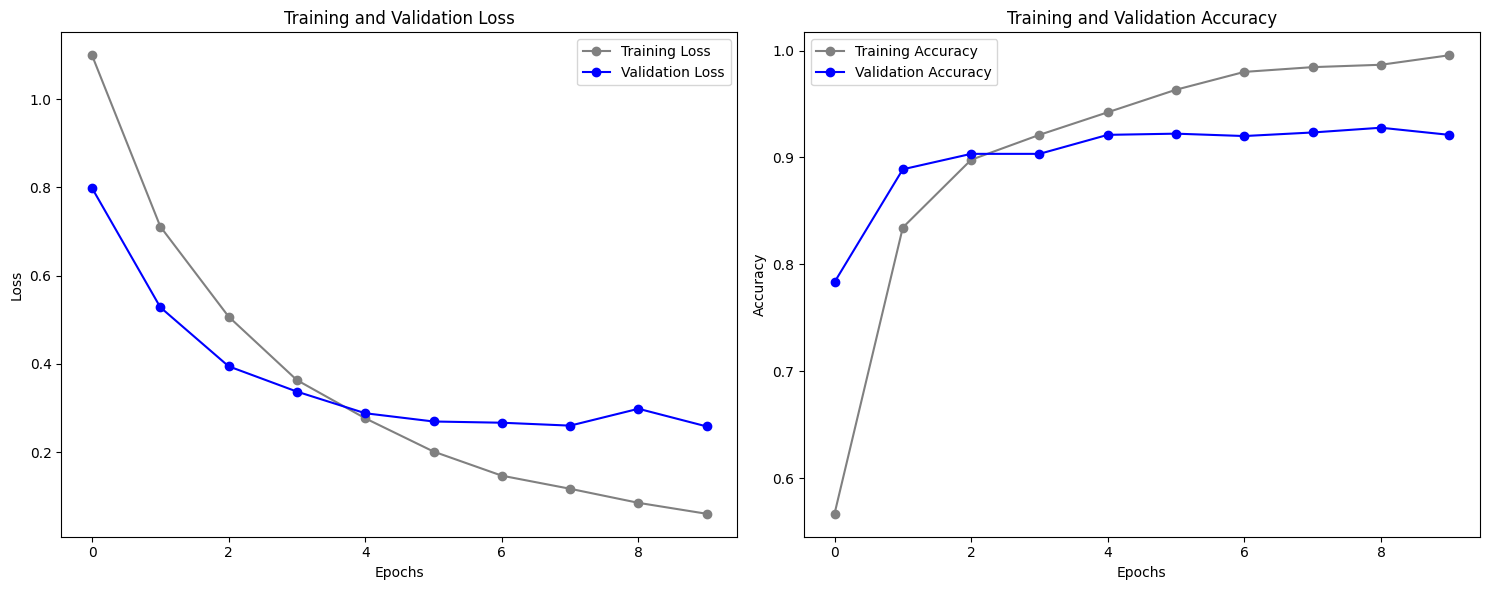

In [8]:
# -----------------------------------------------------------------------------------------------
# Visualize training
# -----------------------------------------------------------------------------------------------

## Unpacking logs into separate lists
training_loss = [log[0] for log in logs]
training_accuracy = [log[1] for log in logs]
validation_loss = [log[2] for log in logs]
validation_accuracy = [log[3] for log in logs]

## Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

## Plotting Loss
ax1.plot(training_loss, label='Training Loss', marker='o', color='gray')
ax1.plot(validation_loss, label='Validation Loss', marker='o', color='blue')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## Plotting Accuracy
ax2.plot(training_accuracy, label='Training Accuracy', marker='o', color='gray')
ax2.plot(validation_accuracy, label='Validation Accuracy', marker='o', color='blue')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

## Show plot
plt.tight_layout()
plt.show()

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
       More important than our validation is our test dataset. What we will do is to classify the test data and compare the predicted values with the real ones to generate a confussion matrix and an accuracy score.
    </p>
</div>

In [9]:
# -----------------------------------------------------------------------------------------------
# Test Classifier
# -----------------------------------------------------------------------------------------------
## Function to predict of text category
def predict_category(text, model, tokenizer, category_to_code):
    
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Ensure model is in evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class index using argmax
    prediction = outputs.logits.argmax(-1).item()

    # Map the predicted index back to the class name using the inverted category_to_code dictionary
    code_to_category = {code: category for category, code in category_to_code.items()}
    predicted_class = code_to_category[prediction]

    return predicted_class

In [10]:
# -----------------------------------------------------------------------------------------------
# Classify and evaluate
# -----------------------------------------------------------------------------------------------
test_df['true_label'] = test_df[['education', 'experience', 'skills']].idxmax(axis=1)
test_df['predicted_label'] = test_df['text'].apply(lambda x: predict_category(x, model, tokenizer, category_to_code))
test_df

,text,education,experience,skills,true_label,predicted_label
0,education and training,1.0,0.0,0.0,education,education
1,taj institute,1.0,0.0,0.0,education,education
2,042014,1.0,0.0,0.0,education,education
3,bachelors degree: computer science,1.0,0.0,0.0,education,education
4,faculty balkh university,1.0,0.0,0.0,education,education
...,...,...,...,...,...,...
9485,"cloud orchestrationautomation: cloudformation,...",0.0,0.0,1.0,skills,skills
9486,"application delivery: codepipeline, codecommit...",0.0,0.0,1.0,skills,skills
9487,"data protection: aws certificate manager, kms,...",0.0,0.0,1.0,skills,skills
9488,monitoring event management: aws cloudwatch ev...,0.0,0.0,1.0,skills,skills


Accuracy: 0.9064


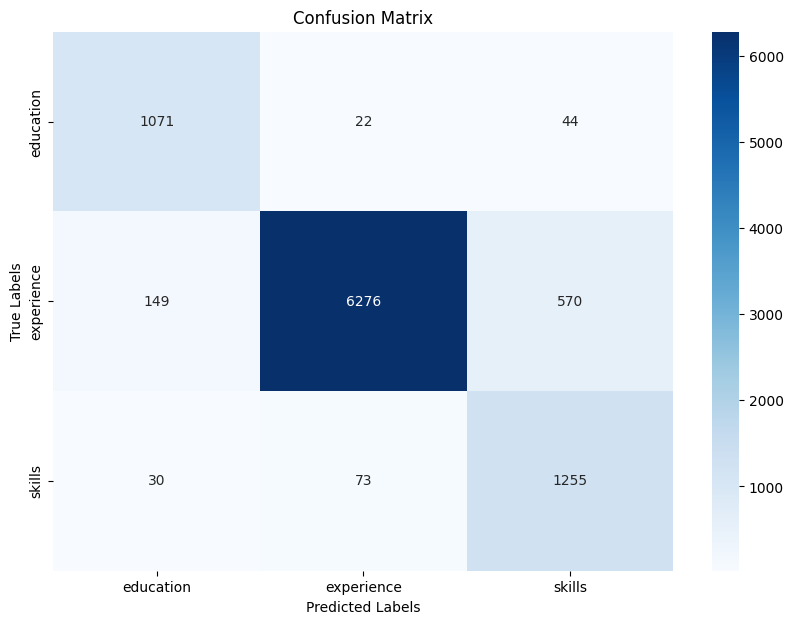

In [11]:
# -----------------------------------------------------------------------------------------------
# See results
# -----------------------------------------------------------------------------------------------

## Extract true labels and predicted labels
true_labels = test_df['true_label'].tolist()
predicted_labels = test_df['predicted_label'].tolist()

## Calculate the confusion matrix and accuracy
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

## Print accuracy
print(f"Accuracy: {accuracy:.4f}")

## Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories.unique(),
            yticklabels=categories.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
       In our model, it's evident that a significant portion of the entries falls under the 'experience' category, which aligns well with our expectations. Given that experience is a critical factor for job roles, our model's proficiency in pinpointing these specific entries is crucial. This observation reinforces the notion of utilizing this model on our 'Jobs' dataset. By doing so, we can effectively align the structured 'Resources' data with the newly categorized 'Jobs' data, facilitating a more precise matching process.
    </p>
</div>

In [12]:
# -----------------------------------------------------------------------------------------------
# Export Classifier
# -----------------------------------------------------------------------------------------------
torch.save(model.state_dict(), './classifier.pt')

## Job Matching Score

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To kick things off, we'll deploy our classifier on the job descriptions, generating similarly categorized data segments. This will enable us to compare the requirements specified in job postings with the qualifications of potential candidates.
    </p>
</div>

In [13]:
# -----------------------------------------------------------------------------------------------
# Classify job text
# -----------------------------------------------------------------------------------------------

## Transform free text into lines
df_jobs_clean = (
    pd.DataFrame(extract_lines(df_job, 'job_text').apply(clean_text), columns=['text'])
    .reset_index()
    .rename({"level_0": "job_id", "level_1": "line_nbr"}, axis=1)
)
df_jobs_clean = df_jobs_clean[df_jobs_clean['text'] != ''][['job_id', 'text']]

## Predict text class
df_jobs_clean['class'] = df_jobs_clean['text'].apply(lambda x: predict_category(x, model, tokenizer, category_to_code))

## Group back text in lists
df_jobs_agg = df_jobs_clean.groupby(['job_id', 'class'])['text'].apply(list).unstack(fill_value=[])

## Join the lists into text divided by new lines
for col in df_jobs_agg.columns:
    df_jobs_agg[col] = df_jobs_agg[col].apply(lambda texts: '\n'.join(texts))

## A litle more cleaning
df_jobs_agg = df_jobs_agg.fillna('')
df_jobs_agg.reset_index(inplace=True)

## Join back the data
df_jobs_parsed = pd.merge(
    df_job.reset_index().rename({"index": "job_id"}, axis=1),
    df_jobs_agg, how='left' , on='job_id'
    )

## Show the parsed data
df_jobs_parsed

,job_id,job_title,job_text,education,experience,skills
0,0,Data Entry Clerk,Ref ID: 01400-0012012592Classification: Data E...,,ref id: 01400-0012012592classification: data e...,classification: compensation:
1,1,"Lead Systems Engineer, Compute and Operations","Overview:\nLead, Systems Engineering at Macy’s...",qualifications:\nmams and babs in computer sci...,"overview:\nlead, systems engineering at macys ...",essential functions:\neducationexperience:\nco...
2,2,Sr. Software Engineer,Ref ID: 01000-0012046528Classification: Sr. So...,"bachelor's degree in computer science, compute...",ref id: 01000-0012046528classification: sr. so...,8 years of professional experience in software...
3,3,Team Member / Crew Member - Burger King #00649,Team Member\nOpportunity Awaits!\nCarrols owns...,,opportunity awaits!\ncarrols owns and operates...,team member\nthe team member position requires...
4,4,Revenue Strategy Analyst / Senior Analyst,"When you join the Greyhound family, you become...",,"when you join the greyhound family, you become...",
...,...,...,...,...,...,...
995,995,Loss Prevention Detective,"All 1,000 of our Marshalls stores embrace disc...",,"all 1,000 of our marshalls stores embrace disc...",excellent communication skills and sound judgm...
996,996,Software Engineer Fullstack,Job Summary:American Car Center is seeking a S...,education and certifications:\na bachelors deg...,job summary:american car center is seeking a s...,"build and support web applications, websites, ..."
997,997,Security Officer Data Center,"At Allied Universal®, we continue to build an ...",,"at allied universal, we continue to build an i...",qualificationsrequirements:\ndisplay exception...
998,998,LP Detective,Style is never in short supply at our more tha...,,style is never in short supply at our more tha...,excellent communication skills and sound judgm...


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        After structuring the data, our next step is to construct a detailed matrix that cross-references each job listing with every potential candidate, capturing their education, experience, and skills. Noting the reliable categorization of 'experience', it presents a solid base to potentially anchor our affinity classifier. This tool aims to facilitate the pairing of job openings with the most fitting applicants. However, before committing to this direction, we'll first establish a methodology to evaluate the efficacy of using these three vectors—education, experience, and skills—alongside the textual data. This preliminary assessment will guide us in determining the most effective approach for our classifier.
    </p>
</div>

In [14]:
# -----------------------------------------------------------------------------------------------
# Get the cross product
# -----------------------------------------------------------------------------------------------

## Let's use some samples:
sample_job = df_jobs_parsed.copy().sample(n=300)
sample_resource = df_resource.copy().sample(n=100)

## Cross df
cross_df = sample_job.merge(sample_resource.reset_index(), how = 'cross')

## Rename  and select columns
columns_to_rename = {
    'job_id': 'job_id', 
    'job_title': 'job_title',
    'education': 'job_education',
    'experience': 'job_experience',
    'skills': 'job_skills',
    'job_text': 'job_text',

    'index': 'resource_id',
    'resource_title': 'resource_title',
    'resource_title': 'resource_title',
    'resource_education': 'resource_education',
    'resource_experience': 'resource_experience',
    'resource_skills': 'resource_skills',
    'resource_text': 'resource_text',
    }

cross_df = cross_df.rename(columns=columns_to_rename)[list(columns_to_rename.values())] 
cross_df.to_csv('./cross_df.csv')

## Visualize df
cross_df


,job_id,job_title,job_education,job_experience,job_skills,job_text,resource_id,resource_title,resource_education,resource_experience,resource_skills,resource_text
0,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,216,senior software engineer,EDUCATION\n2012\nMASTER OF SCIENCE | TELECOMMU...,EXPERIENCE\n01/2013 to PRESENT\nSENIOR SOFTWAR...,"LTE, WCDMA, Wireless Networks, Wireless Tools:...","Jessica Claire\nMontgomery Street, San Francis..."
1,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,303,graduate lab assistant,EDUCATION AND TRAINING\nJawaharlal Nehru Techn...,"WORK EXPERIENCE\nAcrt, Inc. - Graduate Lab Ass...","Proficiency in programming languages C, C++ an...",JESSICA\nCLAIRE\nresumesample@example.com\n(55...
2,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,235,data entry specialist,EDUCATION AND TRAINING\nJUN 1999\nHigh School ...,EXPERIENCE\n03/2016 to PRESENT\nDATA ENTRY SPE...,Performance driven.\n10+years combined experie...,"Jessica Claire\nMontgomery Street, San Francis..."
3,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,252,lead analyst business analyst,EDUCATION\nMahendra Morang Multiple Campus\nNe...,WORK HISTORY\nHexagon - Lead Analyst / Busines...,SQL\nClearquest\nClearcase\nSalesforce\nXML Sp...,JESSICA\nCLAIRE\nresumesample@example.com\n(55...
4,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,601,senior researcher,Education and Training\nA.A.S.: Animal Health ...,"Professional Experience\nSenior Researcher, 07...",Carbohydrate raw materials and mycotoxins\nQua...,"Jessica Claire\nMontgomery Street, San Francis..."
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,711,technical support engineer (data protection ad...,EDUCATION\nXXX1\nMaster of Science | Telecommu...,EXPERIENCE\n02/XXX6\nTECHNICAL CONSULTANT\nPer...,None,"Jessica Claire\nMontgomery Street, San Francis..."
29996,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,620,business analyst,Education\nHigh School Diploma: 04/2012\nBosto...,"Experience\nBusiness Analyst, 12/2020 to 10/20...",Microsoft Office\nJIRA\nProcess development\nW...,Jessica Claire\n100 Montgomery St. 10th Floor ...
29997,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,997,hr service delivery analyst,Education and Training\n08/2018\nMaster of Sci...,Experience\n11/2021 to Current\nHR Service Del...,"APPLICATIONS USED :Service Now, Case Managemen...",Jessica Claire\n100 Montgomery St. 10th Floor\...
29998,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an ope

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        We will introduce two auxiliary functions designed to assess the performance of our matching scores across different categories. These functions will provide insights into how effectively our system aligns candidates with job listings based on various criteria.
    </p>
    <p>
        The first function will allow us to see the distribution of a particular simmilarity, the second function produces a table of a dataframe where we can see basic statistics of each classifier.
    </p>
</div>

In [15]:
# -----------------------------------------------------------------------------------------------
# Function to plot similarities
# -----------------------------------------------------------------------------------------------
def plot_similarity_distributions(df, column, title):
    # Select the similarity scores
    sim_scores = df[column].dropna()

    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle(f'Similarity Score Distribution for {title}')

    # Histogram of the similarity scores
    axes[0].hist(sim_scores, bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title('Histogram of Similarity Scores')
    axes[0].set_xlabel('Similarity Score')
    axes[0].set_ylabel('Frequency')

    # Boxplot of the similarity scores
    axes[1].boxplot(sim_scores, vert=True, patch_artist=True)
    axes[1].set_title('Boxplot of Similarity Scores')
    axes[1].set_xlabel('Similarity Score')
    axes[1].set_ylabel('Value')

    # Display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -----------------------------------------------------------------------------------------------
# Function to print similarities
# -----------------------------------------------------------------------------------------------
def print_summary_table(df):
    # Define the table and its column names
    table = PrettyTable()
    table.field_names = ["Category", "Mean", "Median", "Std Dev", "Min", "Max"]

    categories = ['education', 'experience', 'skills', 'text']
    summary_stats = {'Mean': [], 'Median': [], 'Std Dev': [], 'Min': [], 'Max': []}

    for category in categories:
        column_name = f'sim_{category}'

        mean_val = df[column_name].mean()
        median_val = df[column_name].median()
        std_dev_val = df[column_name].std()
        min_val = df[column_name].min()
        max_val = df[column_name].max()

        # Append statistics to their respective lists in the dictionary
        summary_stats['Mean'].append(mean_val)
        summary_stats['Median'].append(median_val)
        summary_stats['Std Dev'].append(std_dev_val)
        summary_stats['Min'].append(min_val)
        summary_stats['Max'].append(max_val)

        table.add_row([
            category.capitalize(), 
            f"{mean_val:.2f}", 
            f"{median_val:.2f}", 
            f"{std_dev_val:.2f}", 
            f"{min_val:.2f}", 
            f"{max_val:.2f}"
        ])

   # Calculate the average of each summary statistic, ignoring NaN values
    avg_stats = {
        stat: (sum(values) / len(values) if len(values) > 0 else 0) for stat, values in summary_stats.items()
    }

    # Add the "AVERAGE" row to the table
    table.add_row([
        "Average",
        f"{avg_stats['Mean']:.2f}",
        f"{avg_stats['Median']:.2f}",
        f"{avg_stats['Std Dev']:.2f}",
        f"{avg_stats['Min']:.2f}",
        f"{avg_stats['Max']:.2f}"
    ])

    # Print the table
    print(table)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        With our datasets prepared and our evaluation framework in place, we proceed to analyze each pair of corresponding fields (such as raw text, education, experience, and skills) for their cosine similarity. This is accomplished using sentence transformers. Specifically, we encode the content of these columns and then assess their similarity using the 'all-miniLM-L6-v2' model from sentence transformers. This model translates sentences and paragraphs into a 384-dimensional vector space, making it suitable for tasks like clustering or semantic search. In our context, we'll employ it solely to gauge similarity between job listings and candidate profiles.
    </p>
    <p>
        The outcome of this procedure is a set of similarity scores for each comparison, providing a quantitative basis for assessing matches between jobs and potential candidates.
    </p>
</div>

In [16]:
# -----------------------------------------------------------------------------------------------
# Semantic simmilarity function:
# -----------------------------------------------------------------------------------------------

# Function to calculate semantic similarity
def calculate_semantic_similarity(text1, text2, model):
    
    # Check for empty or NaN texts
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    
    # Encode the texts to get the embeddings
    embeddings = model.encode([text1, text2])
    
    # Calculate cosine similarity
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

# -----------------------------------------------------------------------------------------------
# Compute similitude
# -----------------------------------------------------------------------------------------------

# Load a pre-trained Sentence Transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_model = sentence_model.to(device)

# Column pairs to process
column_pairs = [
    ('resource_education', 'job_education'),
    ('resource_experience', 'job_experience'),
    ('resource_skills', 'job_skills'),
    ('resource_text', 'job_text')
]

sim_df = cross_df.copy()

# Calculate similarities
for col1, col2 in column_pairs:
    sim_col_name = f'sim_{col1.split("_")[1]}'
    sim_df[sim_col_name] = sim_df.apply(lambda row: calculate_semantic_similarity(row[col1], row[col2], sentence_model), axis=1)

sim_df

,job_id,job_title,job_education,job_experience,job_skills,job_text,resource_id,resource_title,resource_education,resource_experience,resource_skills,resource_text,sim_education,sim_experience,sim_skills,sim_text
0,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,216,senior software engineer,EDUCATION\n2012\nMASTER OF SCIENCE | TELECOMMU...,EXPERIENCE\n01/2013 to PRESENT\nSENIOR SOFTWAR...,"LTE, WCDMA, Wireless Networks, Wireless Tools:...","Jessica Claire\nMontgomery Street, San Francis...",0.178673,0.272756,0.330658,0.185763
1,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,303,graduate lab assistant,EDUCATION AND TRAINING\nJawaharlal Nehru Techn...,"WORK EXPERIENCE\nAcrt, Inc. - Graduate Lab Ass...","Proficiency in programming languages C, C++ an...",JESSICA\nCLAIRE\nresumesample@example.com\n(55...,0.232559,0.289568,0.401305,0.428331
2,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,235,data entry specialist,EDUCATION AND TRAINING\nJUN 1999\nHigh School ...,EXPERIENCE\n03/2016 to PRESENT\nDATA ENTRY SPE...,Performance driven.\n10+years combined experie...,"Jessica Claire\nMontgomery Street, San Francis...",0.221508,0.204572,0.361706,0.320535
3,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,252,lead analyst business analyst,EDUCATION\nMahendra Morang Multiple Campus\nNe...,WORK HISTORY\nHexagon - Lead Analyst / Busines...,SQL\nClearquest\nClearcase\nSalesforce\nXML Sp...,JESSICA\nCLAIRE\nresumesample@example.com\n(55...,0.135802,0.317388,0.120015,0.331665
4,153,Design Program Manager,"and you are a person who:\nmasters degree, pmp...",bank of america experience design at bank of a...,job description:\ndesign program manager\nprod...,Job Description:\nDesign Program Manager\nBank...,601,senior researcher,Education and Training\nA.A.S.: Animal Health ...,"Professional Experience\nSenior Researcher, 07...",Carbohydrate raw materials and mycotoxins\nQua...,"Jessica Claire\nMontgomery Street, San Francis...",-0.015841,0.289318,0.171638,0.245167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,711,technical support engineer (data protection ad...,EDUCATION\nXXX1\nMaster of Science | Telecommu...,EXPERIENCE\n02/XXX6\nTECHNICAL CONSULTANT\nPer...,None,"Jessica Claire\nMontgomery Street, San Francis...",0.295228,0.404125,NaN,0.499738
29996,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,620,business analyst,Education\nHigh School Diploma: 04/2012\nBosto...,"Experience\nBusiness Analyst, 12/2020 to 10/20...",Microsoft Office\nJIRA\nProcess development\nW...,Jessica Claire\n100 Montgomery St. 10th Floor ...,0.116322,0.483985,0.106817,0.494732
29997,492,Analytics Consultant,qualifications:\ndesired: a bsba degree or hig...,strategic staffing solutions has an opening! s...,contract length:\nthe s3 difference the s3 dif...,STRATEGIC STAFFING SOLUTIONS HAS AN OPENING! ...,997,hr service delivery analyst,Education

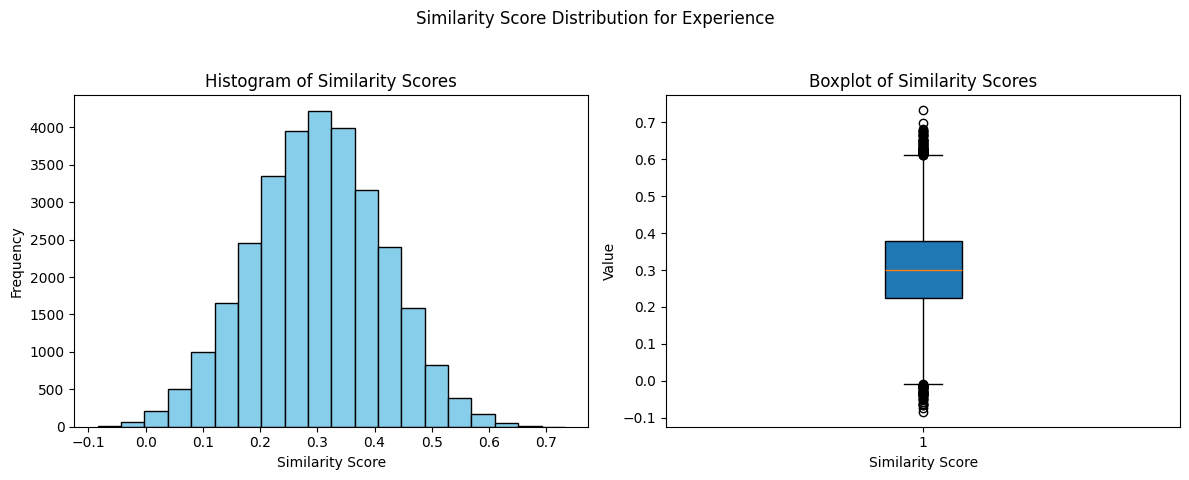

+------------+------+--------+---------+-------+------+
|  Category  | Mean | Median | Std Dev |  Min  | Max  |
+------------+------+--------+---------+-------+------+
| Education  | 0.19 |  0.16  |   0.13  | -0.14 | 0.70 |
| Experience | 0.30 |  0.30  |   0.11  | -0.08 | 0.73 |
|   Skills   | 0.22 |  0.21  |   0.15  | -0.10 | 0.75 |
|    Text    | 0.33 |  0.33  |   0.11  | -0.04 | 0.79 |
|  Average   | 0.26 |  0.25  |   0.13  | -0.09 | 0.74 |
+------------+------+--------+---------+-------+------+


In [17]:
# -----------------------------------------------------------------------------------------------
# See results
# -----------------------------------------------------------------------------------------------
plot_similarity_distributions(sim_df, 'sim_experience', 'Experience')
print_summary_table(sim_df)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Now that we've generated similarity metrics across various fields, our next step involves establishing a benchmark for evaluation. To achieve this, we will utilize the cutting-edge capabilities of Chat GPT-3.5 by OpenAI, leveraging it to assess the affinity between resumes and job descriptions. By submitting the text data from both resumes and job listings to Chat GPT-3.5, we will request it to assign an affinity score ranging from 0 to 1, where 0 represents no affinity and 1 indicates perfect alignment.
    </p>
    <p>
        This external evaluation will serve as our 'ground truth' to validate the effectiveness of our model. Ideally, the similarity scores generated by our model should closely align with the affinity scores provided by Chat GPT-3.5. A strong correlation would indicate that our model is performing well. Conversely, significant discrepancies would suggest a need to recalibrate our approach. Essentially, this phase involves constructing a regression model that compares the affinity scores from Chat GPT-3.5 against the numerical similarity scores we've computed, allowing us to fine-tune our model for optimal performance.
    </p>
</div>

In [18]:
# -----------------------------------------------------------------------------------------------
# Strategy to ask GPT for a classification
# -----------------------------------------------------------------------------------------------

## Function to measure similarity on GPT 
def calculate_gpt_sim_score(resume_text, job_posting_text):

    client = OpenAI(
      api_key = os.getenv("OPENAI_KEY", "")
    )

    try:
        # Construct a prompt
        messages = [
            { "role": "system",
              "content": "You are an HR guru capable of matching job requirements with resumes using a scale between 0 and 1 as a representation of matching score. Your answer is always a floating number and nothing else" 
            },
            { "role": "user",
              "content": f""" Give me a matching score between this RESUME: {resume_text[0:1900]} and this JOB POSTING: {job_posting_text[0:1900]}. Provide answer as a simple number, ntohing else.""" 
            }
        ]

        # Call the OpenAI API with temp 0 to have an strict answer.
        response =  client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            max_tokens=4096,
            temperature=0
        )

        # Extract the score from the response
        score = response.choices[0].message.content
        return score
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## Function to process data
def evaluate_model_vs_gpt(df):

    model_list_ed = []
    model_list_xp = []
    model_list_sk = []
    model_list_tx = []
    gpt_list = []

    for index, row in df.iterrows():


        resource_text = row['resource_text']
        job_text = row['job_text']
        model_list_ed.append(row['sim_education'])
        model_list_xp.append(row['sim_experience'])
        model_list_sk.append(row['sim_skills'])
        model_list_tx.append(row['sim_text'])
        gpt_list.append(calculate_gpt_sim_score(resource_text, job_text))
    
    evaluated_df = pd.DataFrame({ 
        'iteration': index,
        'model_education': model_list_ed,
        'model_experience': model_list_xp,
        'model_skill': model_list_sk,
        'model_text': model_list_tx,
        'gpt_score': gpt_list
        })
    return evaluated_df

## Data to send
top_per_task = sim_df.groupby('job_id', as_index=False).apply(lambda x: x.sort_values(by='sim_text', ascending=False).head(1)).reset_index(drop=True)

## Now, sort 'top_per_task' by 'sim_text' to get the overall top entries and take the top 100
top_100 = top_per_task.sort_values('sim_text', ascending=False).head(100)

## Reset index if needed
top_100 = top_100.reset_index(drop=True)

top_100[['resource_id', 'job_id', 'resource_title', 'job_title', 'sim_education', 'sim_experience', 'sim_skills', 'sim_text']]

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_7432/2592342530.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_task = sim_df.groupby('job_id', as_index=False).apply(lambda x: x.sort_values(by='sim_text', ascending=False).head(1)).reset_index(drop=True)


,resource_id,job_id,resource_title,job_title,sim_education,sim_experience,sim_skills,sim_text
0,791,727,analytics engineer,Data Engineer I,0.363668,0.650488,0.087960,0.785036
1,292,83,aws devops engineer,Systems Engineer III,0.482336,0.585500,0.658646,0.777141
2,737,671,"web developer, web site admin",Software Engineer III- Java Developer,0.156952,0.199605,0.561069,0.763320
3,791,274,analytics engineer,Big Data Engineer,0.080787,0.636954,0.169447,0.749323
4,76,505,android developer,Sr. Android Developer,0.438303,0.552832,NaN,0.739023
...,...,...,...,...,...,...,...,...
95,399,467,wholesale sales coordinator,Retail Part Time Seasonal Merchandise Associate,-0.020324,0.584759,-0.037465,0.601561
96,399,50,wholesale sales coordinator,TJ Maxx @Winrock part time Retail Merchandise ...,-0.020324,0.588029,-0.037465,0.600550
97,399,185,wholesale sales coordinator,Retail Associate Part Time Now Hiring,-0.020324,0.588324,-0.037465,0.599694
98,756,541,data entry specialist,Data Entry Associate,0.265559,0.437121,0.408569,0.599599


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        OpenAI query
    </p>
</div>

In [19]:
# -----------------------------------------------------------------------------------------------
# Query GPT classification
# -----------------------------------------------------------------------------------------------

# Query GPT data
gpt_df = evaluate_model_vs_gpt(top_100)

# Extract numeric data
gpt_df['gpt_score'] = gpt_df['gpt_score'].astype(str).str.extract('(\d+\.?\d*)')

# Convert the extracted strings to float
gpt_df['gpt_score'] = pd.to_numeric(gpt_df['gpt_score'], errors='coerce')

gpt_df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,iteration,model_education,model_experience,model_skill,model_text,gpt_score
0,99,0.363668,0.650488,0.087960,0.785036,0.75
1,99,0.482336,0.585500,0.658646,0.777141,0.45
2,99,0.156952,0.199605,0.561069,0.763320,0.60
3,99,0.080787,0.636954,0.169447,0.749323,0.45
4,99,0.438303,0.552832,NaN,0.739023,0.45
...,...,...,...,...,...,...
95,99,-0.020324,0.584759,-0.037465,0.601561,0.40
96,99,-0.020324,0.588029,-0.037465,0.600550,0.40
97,99,-0.020324,0.588324,-0.037465,0.599694,0.40
98,99,0.265559,0.437121,0.408569,0.599599,0.60


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Once we have the GPT data, we can visualize how raw text data and how experience data compares to it.
    </p>
</div>

In [20]:
# -----------------------------------------------------------------------------------------------
# Evaluate model vs GPT
# -----------------------------------------------------------------------------------------------

## Function to score 
def compare_scores(df, compare_column):
    
    # Ensure the column exists in the DataFrame
    if compare_column not in df.columns or 'gpt_score' not in df.columns:
        print("The specified column(s) do not exist in the DataFrame.")
        return

    # Extracting the relevant columns
    gpt_scores = df['gpt_score']
    model_scores = df[compare_column]

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(gpt_scores, model_scores)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(gpt_scores, label='GPT Score', marker='o')
    plt.plot(model_scores, label=f'{compare_column} Score', linestyle='--', marker='x')
    plt.title('GPT Score vs. Model Score Comparison')
    plt.xlabel('Data Points')
    plt.ylabel('Scores')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print MAE
    print(f"Mean Absolute Error (MAE) between GPT Score and {compare_column} Score: {mae:.2f}")

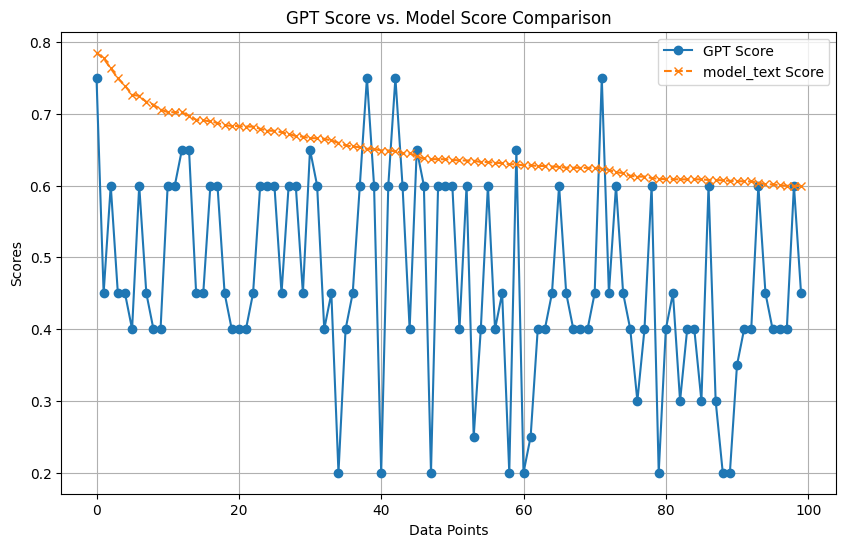

Mean Absolute Error (MAE) between GPT Score and model_text Score: 0.19


In [21]:
compare_scores(gpt_df, 'model_text')

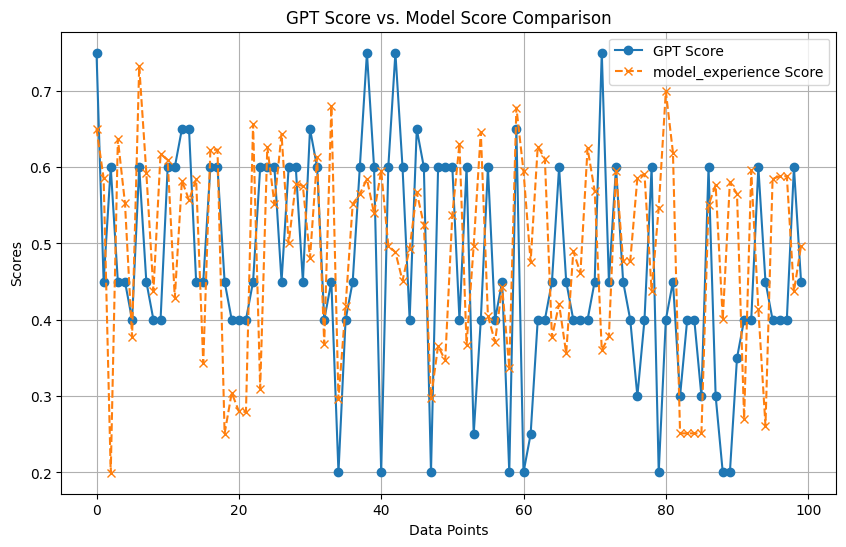

Mean Absolute Error (MAE) between GPT Score and model_experience Score: 0.15


In [22]:
compare_scores(gpt_df, 'model_experience')

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The analysis reveals that the experience metrics align closely with the affinity scores provided by GPT, indicating that focusing on experience data from both resumes and job descriptions can be a key strategy for our matching model. By extracting experience-related information and employing sentence transformers to evaluate similarity, we establish a reliable method for gauging potential matches.
    </p>
    <p>
        This similarity score, derived from a comparison of experience fields, will serve as a crucial input for our matching model. We now have a framework that includes candidates, job listings, and a quantifiable affinity score, setting the stage for the final step: generating the matches. This process involves algorithmically pairing candidates with job opportunities based on the computed affinity scores, effectively streamlining the task of matching the right candidates with the right jobs.
    </p>
</div>

In [23]:
# -----------------------------------------------------------------------------------------------
# Save classified data
# -----------------------------------------------------------------------------------------------

sim_df[['job_id', 'resource_id', 'sim_text']].rename({'sim_text': 'score'}, axis=1).to_csv('./data/score.csv', index=False)
sample_job[['job_id', 'job_title', 'job_text']].to_csv('./data/job.csv', index=False)
sample_resource.reset_index().rename({'index': 'resource_id'}, axis=1)[['resource_id', 'resource_title', 'resource_text']].to_csv('./data/resource.csv', index=False)


## Matching Problem

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        At this juncture, we have delineated a pool of job opportunities, denoted as <b><i>J</i></b>, and a pool of available resources, denoted as <b><i>R</i></b>. For each pairing of job <i>j</i> and resource <i>r</i>, we've established an affinity score within a set <b><i>S</i></b>, derived from a meticulously crafted text classifier and a sentence similarity assessment mechanism. However, to model a job market more accurately, we must consider additional factors beyond mere affinity, such as temporal elements <b><i>T</i></b> and financial margins <b><i>M</i></b>.
    </p>
    <p>
       To address these complexities, we propose the development of functions capable of simulating these additional dimensions, thereby enabling us to estimate potential revenue and costs associated with each job-resource pairing. We introduce two pivotal thresholds: <i>thres_qualified</i> for candidates who can seamlessly transition into a role, and <i>thres_trainable</i> for those who may be suitable post-training. Training entails both a temporal and financial commitment, influencing the overall feasibility of a match and is ultimately determined by our affinity matching score previously calculated. We say that <i>thres_qualified</i> is necessariyl greater than <i>thres_trainable</i>. There is implied here another level which is when the potential worker is below the <i>thres_trainable</i> in such scenario, the candidate will not be able to perform the job.
    </p>
        Moreover, we'll categorize candidates as either previously employed or freshly entering the market. This classification aids in calculating the hiring timeline and associated costs, including daily rates and total hiring expenses. A fixed salary, representative of the job's financial commitment, will be factored into our calculations, impacting the net opportunity value.
    </p>
    <p>
        The interplay of these variables—training necessities, hiring costs, salary discrepancies, and the temporal gap before client billing commences—collectively shapes the opportunity cost. This cost, juxtaposed against potential revenue, yields the opportunity margin. This margin will serve as a critical metric in our matching algorithm, guiding us towards the most financially viable pairings.
    </p>
    <p>
        In essence, our matching model, symbolized as <b><i>(j,r)->R</i></b> (mapping to margin), aims to optimize these interactions of affinity, time and financial values within our simulated environment. This endeavor will necessitate the creation of a data simulation tool, a matching algorithm, and, ultimately, the generation of actionable insights based on our model's outcomes.
    </p>
    <p>
        And all starts with the data...
    </p>
</div>

In [24]:
# -----------------------------------------------------------------------------------------------
# Initial data
# -----------------------------------------------------------------------------------------------

## Call initial data
jobs = pd.read_csv('./data/job.csv', usecols=['job_id', 'job_title'])
resources = pd.read_csv('./data/resource.csv', usecols=['resource_id', 'resource_title'])
scores = pd.read_csv('./data/score.csv')

## Display data
print(f"Jobs df: {jobs.shape}")
display(jobs.head(2))

print(f"Resources df: {resources.shape}")
display(resources.head(2))

print(f"Scores df: {scores.shape}")
display(scores.head(2))

Jobs df: (300, 2)


,job_id,job_title
0,153,Design Program Manager
1,660,"Data Center Linux Engineer - Hillsboro, OR"


Resources df: (100, 2)


,resource_id,resource_title
0,216,senior software engineer
1,303,graduate lab assistant


Scores df: (30000, 3)


,job_id,resource_id,score
0,153,216,0.185763
1,153,303,0.428331


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        At this point our data is lacking the element described above, for that, let's start defining some functions that will allow us to do those programatically.
    </p>
</div>

In [25]:
# -----------------------------------------------------------------------------------------------
# Genearate simulation values functions
# -----------------------------------------------------------------------------------------------

## Function to simulate how many days a job needs to be completed
def simulate_time():
    time_job = int(np.random.normal(60, 15))
    return max(time_job, 1) 

## Function to simulate opporutiniy daily revenue
def simulate_job_revenue():
    revenue = int(np.random.normal(500, 100))
    return max(revenue, 200)

## Function to get thresholds
def simulate_thresholds():
    thres_trainable = 0.7
    thres_qualified = 0.8
    return thres_trainable, thres_qualified

## Function to see if person is initially hired or available
def simulate_status():
    is_hired = np.random.choice([True, False], p=[0.2, 0.8])
    return is_hired

## Function to simulate employee salary if is hired.
def simulate_emp_salary():
    salary = 180
    return salary

## Function to simulate job salary
def simulate_job_salary():
    salary = 180
    return salary

## Function to simulate days and cost of training (daily)
def simulate_training():
    training_days = int(np.random.normal(10, 3))
    training_cost = int(np.random.normal(150, 30))
    return max(training_days, 1), max(training_cost, 100) 

## Function to simulate days and cost of hiring (daily)
def simulate_hiring():
    hiring_days = int(np.random.normal(10, 5))
    hiring_cost = 200
    return max(hiring_days, 5), hiring_cost

def simulate_scale_score(dataframe, column_name):
    # Calculate min and max of the column
    min_val = dataframe[column_name].min()
    max_val = dataframe[column_name].max()
    
    # Apply min-max scaling
    return (dataframe[column_name] - min_val) / (max_val - min_val)



In [26]:
# -----------------------------------------------------------------------------------------------
# Generate simulated market functions
# -----------------------------------------------------------------------------------------------

## Fuction to simulate job conditions
def sim_jobs(dataframe_src):
    dataframe = dataframe_src.copy()
    dataframe['time'] = dataframe.apply(lambda x: simulate_time(), axis=1)
    dataframe['revenue'] = dataframe.apply(lambda x: simulate_job_revenue(), axis=1)
    dataframe['job_salary'] = dataframe.apply(lambda x: simulate_job_salary(), axis=1)
    dataframe['thres_trainable'], dataframe['thres_qualified'] = zip(*dataframe.apply(lambda x: simulate_thresholds(), axis=1))
    dataframe['training_days'], dataframe['training_cost'] = zip(*dataframe.apply(lambda x: simulate_training(), axis=1))
    dataframe['hiring_days'], dataframe['hiring_cost'] = zip(*dataframe.apply(lambda x: simulate_hiring(), axis=1))
    return dataframe

## Function to simulate resources conditions
def sim_resource(dataframe_src):
    dataframe = dataframe_src.copy()
    dataframe['resource_name'] = [get_full_name() for _ in range(len(dataframe))]
    dataframe['is_free'] = True
    dataframe['is_hired'] = dataframe.apply(lambda x: simulate_status(), axis=1)
    dataframe['emp_salary'] = dataframe.apply(lambda x: x['is_hired'] * simulate_emp_salary(), axis=1)
    return dataframe

def sim_score(dataframe_src):
    dataframe = dataframe_src.copy()
    dataframe['score'] = simulate_scale_score(dataframe, 'score')
    return dataframe

## Function to simulate job market
def simulate_market(J, R, S):

    # Merge all simulated data
    job_data = sim_jobs(J)
    resource_data = sim_resource(R)
    score_data = sim_score(S)
    scores_with_jobs = pd.merge(score_data, job_data, on='job_id', how='left')
    scores_with_jobs_resources = pd.merge(scores_with_jobs, resource_data, on='resource_id', how='left')

    # Compute revenue
    market = scores_with_jobs_resources
    market['Revenue'] = market.apply(
        lambda x: x['revenue'] * x['time'] if x['score'] >= x['thres_trainable'] else 0, axis=1
    )

    # Compute salary days
    market['salary_time'] = market.apply(
        lambda x: x['time'] if x['score'] >= x['thres_qualified']
        else  x['training_days'] + x['time'], axis=1
    )
    
    # Compute salary cost
    market['total_salary_cost'] = market.apply(
        lambda x: 0 if x['score'] < x['thres_trainable'] 
              else (x['job_salary'] + (x['job_salary'] - x['emp_salary'])) * x['salary_time'] if x['is_hired'] 
              else x['job_salary'] * x['salary_time'], axis=1
    )
    
    # Compute hiring cost
    market['total_hiring_cost'] = market.apply(
        lambda x: x['hiring_cost'] * x['hiring_days'] if x['is_hired'] is False else 0, axis=1
    )
    
    # Compute training cost
    market['total_train_cost'] = market.apply(
        lambda x: x['training_cost'] * x['training_days'] if x['score'] < x['thres_qualified'] else 0, axis=1)

    # Compute total cost
    market['Cost'] = market.apply(
        lambda x: x['total_salary_cost'] + x['total_hiring_cost'] + x['total_train_cost'], axis=1
    )

    # Compute margin
    market['Margin'] = market.apply(
        lambda x: x['Revenue'] - x['Cost'], axis=1
    )

    # Compute time to incorporate
    market['time_to_incorporate'] = market.apply(
        lambda x: (x['hiring_days'] if not x['is_hired'] else 0) + 
              (x['training_days'] if x['thres_trainable'] <= x['score'] < x['thres_qualified'] else 0), axis=1)



    return market

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Functions above allow us to generate not only the values of jobs and resources, but also the whole market scenario where we have (j,r)->R through a Margin column. Let's visualize this with an initial simulation.
    </p>
</div>

In [27]:
# -----------------------------------------------------------------------------------------------
# Generate simulated market functions
# -----------------------------------------------------------------------------------------------
sim_0 = simulate_market(jobs, resources, scores)
sim_0

,job_id,resource_id,score,job_title,time,revenue,job_salary,thres_trainable,thres_qualified,training_days,...,is_hired,emp_salary,Revenue,salary_time,total_salary_cost,total_hiring_cost,total_train_cost,Cost,Margin,time_to_incorporate
0,153,216,0.276801,Design Program Manager,41,387,180,0.7,0.8,12,...,True,180,0,53,0,0,2688,2688,-2688,0
1,153,303,0.569531,Design Program Manager,41,387,180,0.7,0.8,12,...,False,0,0,53,0,2400,2688,5088,-5088,12
2,153,235,0.439443,Design Program Manager,41,387,180,0.7,0.8,12,...,False,0,0,53,0,2400,2688,5088,-5088,12
3,153,252,0.452875,Design Program Manager,41,387,180,0.7,0.8,12,...,False,0,0,53,0,2400,2688,5088,-5088,12
4,153,601,0.348489,Design Program Manager,41,387,180,0.7,0.8,12,...,False,0,0,53,0,2400,2688,5088,-5088,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,492,711,0.655704,Analytics Consultant,59,562,180,0.7,0.8,8,...,False,0,0,67,0,1600,1560,3160,-3160,8
29996,492,620,0.649663,Analytics Consultant,59,562,180,0.7,0.8,8,...,False,0,0,67,0,1600,1560,3160,-3160,8
29997,492,997,0.592254,Analytics Consultant,59,562,180,0.7,0.8,8,...,False,0,0,67,0,1600,1560,3160,-3160,8
29998,492,521,0.689225,Analytics Consultant,59,562,180,0.7,0.8,8,...,False,0,0,67,0,1600,1560,3160,-3160,8


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        At this stage, we conceptualize our job market as a Bipartite Weighted Graph, where one set of nodes represents the Resources and the other the Jobs. Each potential assignment between a resource and a job is associated with a specific Margin, implying that each assignment carries a cost or benefit. To navigate this complex landscape, we propose utilizing a modified version of the <b>Auction Algorithm </b>.
    </p>
    <p>
         In our adapted Auction Algorithm framework, jobs serve as the auction items for which resources compete, positioning themselves as bidders. The algorithm iteratively seeks an optimal assignment where each resource is matched to a job in a manner that maximizes the overall margin. This iterative bidding process continues until we reach a state of equilibrium, where no resource can improve its margin by switching to a different job.
    </p>
    <p>
         This approach essentially transforms the challenge of job-resource matching into an optimization problem, with the goal of maximizing total profit from the assignments. The margin associated with each potential match drives the bidding process, ensuring that resources are allocated to jobs in a way that optimizes the financial outcomes for the organization. Through this method, we aim to achieve a maximum matching that aligns with the objective of maximizing the profit derived from pairing resources with suitable job opportunities.
    </p>
</div>

In [28]:
# -----------------------------------------------------------------------------------------------
# Auction assignation algorithm
# -----------------------------------------------------------------------------------------------

## Matching function
def auction_algorithm(J, R, M, E=1):

    # Initialize resource prices to 0 and set all jobs as unassigned
    prices = {resource: 0 for resource in R}
    assignment = {job: None for job in J}
    unassigned_jobs = set(J)


    ## Continue the auction until all jobs are assigned
    while unassigned_jobs:
        bids = {}


        ## Each unassigned job bids for its most preferred resource based on current prices
        for job in unassigned_jobs:
            
            # Adjust the margins for each resource by subtracting the current price
            resource_margins = M[job]
            adjusted_margins = {resource: margin - prices[resource] for resource, margin in resource_margins.items()}

            # Identify the best and second-best resources based on adjusted margins
            best_resource, second_best_resource = sorted(adjusted_margins, key=adjusted_margins.get, reverse=True)[:2]

            # Calculate the bid amount as the difference between the best and second-best adjusted margins plus epsilon
            bid_amount = adjusted_margins[best_resource] - adjusted_margins.get(second_best_resource, 0) + E
            bids[(job, best_resource)] = bid_amount


        ## Update assignments and prices based on the bids
        for (job, resource), bid in bids.items():

            ## Accept the bid if it's higher than the current price
            if bid > prices[resource]:

                ## If the resource is already assigned, unassign the previous job
                previous_job = next((j for j, r in assignment.items() if r == resource), None)
                if previous_job:
                    unassigned_jobs.add(previous_job)
                
                # Assign the job to the resource and update the price
                assignment[job] = resource
                prices[resource] = bid
                unassigned_jobs.remove(job)

        ## Reduce epsilon for finer adjustments in subsequent rounds
        E *= 0.9
        if E < 0.01:
            break  # Terminate if epsilon is too small, indicating convergence

    return assignment

## Function that consumes a simulated dataframe to pass to the auction algorithm
def match_market(dataframe):
    M = dataframe.groupby('job_id').apply(lambda x: dict(zip(x.resource_id, x.Margin))).to_dict()
    J = dataframe['job_id'].unique()
    R = dataframe['resource_id'].unique()

    assignment = auction_algorithm(J, R, M)

    assignment_df = pd.DataFrame(list(assignment.items()), columns=['job_id', 'resource_id'])
    assignment_df['Margin'] = assignment_df.apply(lambda x: M.get(x.job_id, {}).get(x.resource_id, np.nan), axis=1)

    return assignment_df

In [29]:
# -----------------------------------------------------------------------------------------------
# Initial simulation
# -----------------------------------------------------------------------------------------------
matching_0 = match_market(sim_0)
matching_0

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_7432/3449256086.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = dataframe.groupby('job_id').apply(lambda x: dict(zip(x.resource_id, x.Margin))).to_dict()


,job_id,resource_id,Margin
0,153,66.0,1239.0
1,660,200.0,29555.0
2,193,81.0,26110.0
3,970,NaN,NaN
4,919,NaN,NaN
...,...,...,...
295,689,NaN,NaN
296,322,499.0,10978.0
297,96,NaN,NaN
298,671,715.0,29614.0


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        We have reached a match! And we can use that to start generating scenarios and reports of how our optimization is working. However, this is a little outside of the scope of this part of the project. For now, let's just show a very simplistic report, where we are not considering all times and salaries of all previously employeed, this is more an operational report of round 0.
    </p>
</div>

In [30]:
# -----------------------------------------------------------------------------------------------
# A very simplistic report
# -----------------------------------------------------------------------------------------------


## Stats view:
df_start = sim_0
df_end = pd.merge(sim_0, matching_0, on=['resource_id', 'job_id'], how='inner')
df_end['new_hire'] = -df_end['is_hired']

# Calculating Total Revenue
total_revenue = df_end['Revenue'].sum()\

# Cycle time
average_time_to_incorporate = df_end['time_to_incorporate'].mean()
average_time_to_incorporate = df_end['time_to_incorporate'].mean()

# Costs
total_salary_cost = df_end['total_salary_cost'].sum()
total_hiring_cost = df_end['total_hiring_cost'].sum()
total_training_cost = df_end['total_train_cost'].sum()

# Employees
initial_employees = df_end['is_hired'].sum()
total_new_hires = df_end['new_hire'].sum()

# Mini Report
print("\nFINANCIAL")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Cost: ${total_salary_cost+total_hiring_cost+total_training_cost:,.2f}")
print(f"  - Total Salary Cost: ${total_salary_cost:,.2f}")
print(f"  - Total Hiring Cost: ${total_hiring_cost:,.2f}")
print(f"  - Total Training Cost: ${total_training_cost:,.2f}")
print(f"Total Margin: ${total_revenue - (total_salary_cost+total_hiring_cost+total_training_cost):,.2f}")

print("\nTIME")
print(f"Average Time to Incorporate: {average_time_to_incorporate:.2f} days")

print("\nEMPLOYEES")
print(f"Initial employees: {initial_employees}")
print(f"Total New Hires: {total_new_hires}")
print(f"Total Employees: {initial_employees + total_new_hires}")




## Trainnings:

## P&L


FINANCIAL
Total Revenue: $4,296,588.00
Total Cost: $2,049,111.00
  - Total Salary Cost: $1,689,120.00
  - Total Hiring Cost: $215,600.00
  - Total Training Cost: $144,391.00
Total Margin: $2,247,477.00

TIME
Average Time to Incorporate: 13.95 days

EMPLOYEES
Initial employees: 29
Total New Hires: 114
Total Employees: 143


## Conclusions

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In this exploration, we've developed a text classifier designed to segment sections of text, facilitating a more structured analysis of job posts and resumes. Beyond this, we've engineered an affinity model that evaluates the compatibility between job listings and candidate profiles. This model's performance is on par with that of CHAT GPT 3.5, demonstrating its effectiveness in capturing the nuances of job suitability.
    </p>
    <p>
        Building on this foundation, we introduced an auction-based mechanism for matching resources to job opportunities in simulated job markets. This approach optimizes the assignment process, ensuring that each match maximizes the overall benefit, as measured by our computed margins.
    </p>
    <p>
        As we conclude, the synergy of these components—text classification, affinity measurement, and auction-based matching—presents a robust framework for streamlining an integrated resource planning optimization model. But that will be better discussed in the demonstration of an application that uses the models and data we built here to show how this tool solves optimization problems starting with only raw text.
    </p>
</div>

========== END OF ACTIVITY ==========